# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [2]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [3]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

[2017-07-06 18:46:24,445] Making new env: CartPole-v0


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards = []
for _ in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [5]:
env.close()

If you ran the simulation above, we can look at the rewards:

In [6]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [12]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [15]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 8.0 Training loss: 1.0938 Explore P: 0.9992
Episode: 2 Total reward: 16.0 Training loss: 1.1453 Explore P: 0.9976
Episode: 3 Total reward: 31.0 Training loss: 1.0974 Explore P: 0.9946
Episode: 4 Total reward: 12.0 Training loss: 1.0567 Explore P: 0.9934
Episode: 5 Total reward: 14.0 Training loss: 1.1136 Explore P: 0.9920
Episode: 6 Total reward: 15.0 Training loss: 1.1877 Explore P: 0.9905
Episode: 7 Total reward: 24.0 Training loss: 1.1698 Explore P: 0.9882
Episode: 8 Total reward: 9.0 Training loss: 1.1261 Explore P: 0.9873
Episode: 9 Total reward: 21.0 Training loss: 1.2232 Explore P: 0.9853
Episode: 10 Total reward: 36.0 Training loss: 1.1544 Explore P: 0.9818
Episode: 11 Total reward: 14.0 Training loss: 1.2412 Explore P: 0.9804
Episode: 12 Total reward: 13.0 Training loss: 1.1143 Explore P: 0.9791
Episode: 13 Total reward: 21.0 Training loss: 1.1974 Explore P: 0.9771
Episode: 14 Total reward: 13.0 Training loss: 1.2640 Explore P: 0.9758
Episode: 15 Total

Episode: 115 Total reward: 19.0 Training loss: 17.7875 Explore P: 0.7831
Episode: 116 Total reward: 21.0 Training loss: 770.7758 Explore P: 0.7815
Episode: 117 Total reward: 23.0 Training loss: 232.5144 Explore P: 0.7797
Episode: 118 Total reward: 11.0 Training loss: 24.6637 Explore P: 0.7789
Episode: 119 Total reward: 16.0 Training loss: 372.0496 Explore P: 0.7776
Episode: 120 Total reward: 21.0 Training loss: 19.7684 Explore P: 0.7760
Episode: 121 Total reward: 21.0 Training loss: 16.0532 Explore P: 0.7744
Episode: 122 Total reward: 15.0 Training loss: 327.5374 Explore P: 0.7733
Episode: 123 Total reward: 17.0 Training loss: 184.4332 Explore P: 0.7720
Episode: 124 Total reward: 8.0 Training loss: 978.8268 Explore P: 0.7714
Episode: 125 Total reward: 14.0 Training loss: 232.3414 Explore P: 0.7703
Episode: 126 Total reward: 8.0 Training loss: 333.2486 Explore P: 0.7697
Episode: 127 Total reward: 12.0 Training loss: 246.8560 Explore P: 0.7688
Episode: 128 Total reward: 13.0 Training los

Episode: 235 Total reward: 27.0 Training loss: 81.2547 Explore P: 0.6499
Episode: 236 Total reward: 9.0 Training loss: 77.2255 Explore P: 0.6493
Episode: 237 Total reward: 7.0 Training loss: 204.1123 Explore P: 0.6489
Episode: 238 Total reward: 21.0 Training loss: 252.3455 Explore P: 0.6475
Episode: 239 Total reward: 10.0 Training loss: 321.4028 Explore P: 0.6469
Episode: 240 Total reward: 7.0 Training loss: 187.9753 Explore P: 0.6464
Episode: 241 Total reward: 9.0 Training loss: 3.1388 Explore P: 0.6459
Episode: 242 Total reward: 11.0 Training loss: 320.9777 Explore P: 0.6452
Episode: 243 Total reward: 12.0 Training loss: 115.9812 Explore P: 0.6444
Episode: 244 Total reward: 18.0 Training loss: 236.5319 Explore P: 0.6433
Episode: 245 Total reward: 9.0 Training loss: 147.1158 Explore P: 0.6427
Episode: 246 Total reward: 11.0 Training loss: 2.7044 Explore P: 0.6420
Episode: 247 Total reward: 15.0 Training loss: 3.5912 Explore P: 0.6411
Episode: 248 Total reward: 14.0 Training loss: 70.6

Episode: 352 Total reward: 17.0 Training loss: 74.9874 Explore P: 0.5526
Episode: 353 Total reward: 11.0 Training loss: 60.0712 Explore P: 0.5520
Episode: 354 Total reward: 12.0 Training loss: 52.7544 Explore P: 0.5514
Episode: 355 Total reward: 12.0 Training loss: 61.4830 Explore P: 0.5507
Episode: 356 Total reward: 19.0 Training loss: 26.0390 Explore P: 0.5497
Episode: 357 Total reward: 15.0 Training loss: 96.2613 Explore P: 0.5489
Episode: 358 Total reward: 14.0 Training loss: 1.5499 Explore P: 0.5481
Episode: 359 Total reward: 11.0 Training loss: 51.1788 Explore P: 0.5475
Episode: 360 Total reward: 26.0 Training loss: 41.7886 Explore P: 0.5461
Episode: 361 Total reward: 22.0 Training loss: 28.0847 Explore P: 0.5450
Episode: 362 Total reward: 17.0 Training loss: 2.2781 Explore P: 0.5441
Episode: 363 Total reward: 10.0 Training loss: 52.2662 Explore P: 0.5435
Episode: 364 Total reward: 14.0 Training loss: 50.5347 Explore P: 0.5428
Episode: 365 Total reward: 16.0 Training loss: 27.706

Episode: 466 Total reward: 37.0 Training loss: 1.8332 Explore P: 0.4260
Episode: 467 Total reward: 18.0 Training loss: 1.7573 Explore P: 0.4252
Episode: 468 Total reward: 36.0 Training loss: 14.9492 Explore P: 0.4237
Episode: 469 Total reward: 27.0 Training loss: 57.8401 Explore P: 0.4226
Episode: 470 Total reward: 51.0 Training loss: 28.3782 Explore P: 0.4205
Episode: 471 Total reward: 12.0 Training loss: 13.9499 Explore P: 0.4200
Episode: 472 Total reward: 30.0 Training loss: 6.0095 Explore P: 0.4188
Episode: 473 Total reward: 50.0 Training loss: 45.5374 Explore P: 0.4168
Episode: 474 Total reward: 47.0 Training loss: 43.4832 Explore P: 0.4148
Episode: 475 Total reward: 42.0 Training loss: 15.9521 Explore P: 0.4131
Episode: 476 Total reward: 37.0 Training loss: 19.9695 Explore P: 0.4117
Episode: 477 Total reward: 51.0 Training loss: 2.1902 Explore P: 0.4096
Episode: 478 Total reward: 37.0 Training loss: 9.9936 Explore P: 0.4081
Episode: 479 Total reward: 36.0 Training loss: 21.2480 E

Episode: 579 Total reward: 88.0 Training loss: 3.1229 Explore P: 0.2194
Episode: 580 Total reward: 81.0 Training loss: 2.2725 Explore P: 0.2177
Episode: 581 Total reward: 90.0 Training loss: 1.9848 Explore P: 0.2159
Episode: 582 Total reward: 64.0 Training loss: 15.7333 Explore P: 0.2146
Episode: 583 Total reward: 143.0 Training loss: 45.7310 Explore P: 0.2117
Episode: 584 Total reward: 38.0 Training loss: 5.8100 Explore P: 0.2109
Episode: 585 Total reward: 116.0 Training loss: 179.0548 Explore P: 0.2086
Episode: 586 Total reward: 54.0 Training loss: 6.7066 Explore P: 0.2075
Episode: 587 Total reward: 76.0 Training loss: 63.4357 Explore P: 0.2060
Episode: 588 Total reward: 115.0 Training loss: 1.5456 Explore P: 0.2038
Episode: 589 Total reward: 64.0 Training loss: 1.7028 Explore P: 0.2025
Episode: 590 Total reward: 81.0 Training loss: 88.5288 Explore P: 0.2010
Episode: 591 Total reward: 58.0 Training loss: 3.8937 Explore P: 0.1999
Episode: 592 Total reward: 119.0 Training loss: 1.8696 

Episode: 692 Total reward: 182.0 Training loss: 0.6287 Explore P: 0.0623
Episode: 693 Total reward: 199.0 Training loss: 0.5038 Explore P: 0.0613
Episode: 694 Total reward: 199.0 Training loss: 0.2945 Explore P: 0.0603
Episode: 695 Total reward: 199.0 Training loss: 0.2677 Explore P: 0.0593
Episode: 696 Total reward: 199.0 Training loss: 0.2906 Explore P: 0.0583
Episode: 697 Total reward: 127.0 Training loss: 0.6073 Explore P: 0.0577
Episode: 698 Total reward: 175.0 Training loss: 0.6320 Explore P: 0.0569
Episode: 699 Total reward: 185.0 Training loss: 82.9782 Explore P: 0.0560
Episode: 700 Total reward: 52.0 Training loss: 0.4590 Explore P: 0.0558
Episode: 701 Total reward: 199.0 Training loss: 0.4560 Explore P: 0.0549
Episode: 702 Total reward: 132.0 Training loss: 0.3694 Explore P: 0.0543
Episode: 703 Total reward: 69.0 Training loss: 0.2843 Explore P: 0.0540
Episode: 704 Total reward: 90.0 Training loss: 0.7120 Explore P: 0.0536
Episode: 705 Total reward: 55.0 Training loss: 77.889

Episode: 805 Total reward: 188.0 Training loss: 0.4040 Explore P: 0.0198
Episode: 806 Total reward: 97.0 Training loss: 0.1955 Explore P: 0.0197
Episode: 807 Total reward: 199.0 Training loss: 0.4529 Explore P: 0.0195
Episode: 808 Total reward: 142.0 Training loss: 0.4024 Explore P: 0.0194
Episode: 809 Total reward: 199.0 Training loss: 0.3182 Explore P: 0.0192
Episode: 810 Total reward: 199.0 Training loss: 0.1706 Explore P: 0.0190
Episode: 811 Total reward: 199.0 Training loss: 0.2229 Explore P: 0.0189
Episode: 812 Total reward: 199.0 Training loss: 0.2265 Explore P: 0.0187
Episode: 813 Total reward: 199.0 Training loss: 0.3233 Explore P: 0.0185
Episode: 814 Total reward: 163.0 Training loss: 0.1674 Explore P: 0.0184
Episode: 815 Total reward: 199.0 Training loss: 92.9889 Explore P: 0.0182
Episode: 816 Total reward: 199.0 Training loss: 0.2064 Explore P: 0.0180
Episode: 817 Total reward: 113.0 Training loss: 0.1869 Explore P: 0.0180
Episode: 818 Total reward: 199.0 Training loss: 0.3

Episode: 918 Total reward: 199.0 Training loss: 0.2199 Explore P: 0.0111
Episode: 919 Total reward: 199.0 Training loss: 245.7123 Explore P: 0.0111
Episode: 920 Total reward: 199.0 Training loss: 0.1491 Explore P: 0.0110
Episode: 921 Total reward: 199.0 Training loss: 0.3095 Explore P: 0.0110
Episode: 922 Total reward: 199.0 Training loss: 0.2220 Explore P: 0.0110
Episode: 923 Total reward: 199.0 Training loss: 0.1856 Explore P: 0.0110
Episode: 924 Total reward: 199.0 Training loss: 0.1192 Explore P: 0.0110
Episode: 925 Total reward: 199.0 Training loss: 0.2667 Explore P: 0.0109
Episode: 926 Total reward: 199.0 Training loss: 236.3384 Explore P: 0.0109
Episode: 927 Total reward: 199.0 Training loss: 0.2088 Explore P: 0.0109
Episode: 928 Total reward: 199.0 Training loss: 0.1460 Explore P: 0.0109
Episode: 929 Total reward: 199.0 Training loss: 0.1534 Explore P: 0.0109
Episode: 930 Total reward: 199.0 Training loss: 0.1521 Explore P: 0.0108
Episode: 931 Total reward: 199.0 Training loss:

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

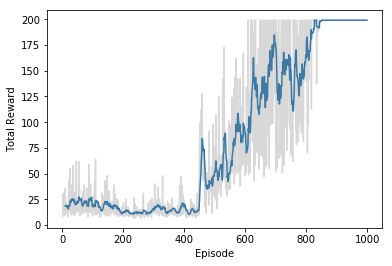

In [19]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [ ]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

In [22]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.